In [2]:
%matplotlib inline


# Plot the decision surfaces of ensembles of trees on the iris dataset


Plot the decision surfaces of forests of randomized trees trained on pairs of
features of the iris dataset.

This plot compares the decision surfaces learned by a decision tree classifier
(first column), by a random forest classifier (second column), by an extra-
trees classifier (third column) and by an AdaBoost classifier (fourth column).

In the first row, the classifiers are built using the sepal width and
the sepal length features only, on the second row using the petal length and
sepal length only, and on the third row using the petal width and the
petal length only.

In descending order of quality, when trained (outside of this example) on all
4 features using 30 estimators and scored using 10 fold cross validation,
we see::

    ExtraTreesClassifier()  # 0.95 score
    RandomForestClassifier()  # 0.94 score
    AdaBoost(DecisionTree(max_depth=3))  # 0.94 score
    DecisionTree(max_depth=None)  # 0.94 score

Increasing `max_depth` for AdaBoost lowers the standard deviation of
the scores (but the average score does not improve).

See the console's output for further details about each model.

In this example you might try to:

1) vary the ``max_depth`` for the ``DecisionTreeClassifier`` and
   ``AdaBoostClassifier``, perhaps try ``max_depth=3`` for the
   ``DecisionTreeClassifier`` or ``max_depth=None`` for ``AdaBoostClassifier``
2) vary ``n_estimators``

It is worth noting that RandomForests and ExtraTrees can be fitted in parallel
on many cores as each tree is built independently of the others. AdaBoost's
samples are built sequentially and so do not use multiple cores.



Automatically created module for IPython interactive environment
DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 10 estimators with features [0, 1] has a score of 0.9133333333333333
ExtraTrees with 10 estimators with features [0, 1] has a score of 0.9266666666666666
AdaBoost with 10 estimators with features [0, 1] has a score of 0.8533333333333334
DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 10 estimators with features [0, 2] has a score of 0.98
ExtraTrees with 10 estimators with features [0, 2] has a score of 0.9933333333333333
AdaBoost with 10 estimators with features [0, 2] has a score of 0.9933333333333333
DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 10 estimators with features [2, 3] has a score of 0.9866666666666667
ExtraTrees with 10 estimators with features [2, 3] has a score of 0.9933333333333333
AdaBoost with 10 estimators with features [2, 3] has a score of

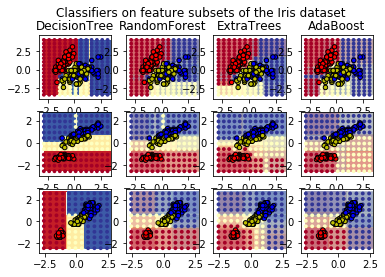

In [3]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 10
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]


pairs = ([0, 1]
             , [0, 2]
             #, [0, 3]
             #, [1, 2]
             #, [1, 3]
             , [2, 3]
            )

for pair in pairs:
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(len(pairs), 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()


# Feature importances with forests of trees


This examples shows the use of forests of trees to evaluate the importance of
features on an artificial classification task. The red bars are the feature
importances of the forest, along with their inter-trees variability.

As expected, the plot suggests that 3 features are informative, while the
remaining are not.



Automatically created module for IPython interactive environment
Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


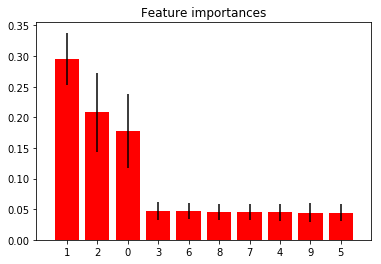

In [4]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()